# <center>Прогнозирование биологического ответа

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import hyperopt
from hyperopt import hp, fmin, tpe, Trials
from sklearn.model_selection import cross_val_score
import optuna

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('seaborn')

In [3]:
data = pd.read_csv('_train_sem09.csv')
X = data.drop(['Activity'], axis=1)
y = data['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

In [194]:
# создаем модель логистической регрессии с параметрами по умолчанию,
# обучаем ее на тренировочных данных и выводим значение f1-score на тестовом наборе
log_reg = linear_model.LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
f1_lr_initial = metrics.f1_score(y_test, y_test_pred)
print('f1_score на тестовом наборе для базовой модели логистической регрессии: {:.3f}'.format(f1_lr_initial))

f1_score на тестовом наборе для базовой модели логистической регрессии: 0.780


In [195]:
# создаем модель случайного леса с параметрами по умолчанию,
# обучаем ее на тренировочных данных и выводим значение f1-score на тестовом наборе
rf = ensemble.RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
f1_rf_initial = metrics.f1_score(y_test, y_test_pred)
print('f1_score на тестовом наборе для базовой модели случайного леса: {:.3f}'.format(f1_rf_initial))

f1_score на тестовом наборе для базовой модели случайного леса: 0.805


In [196]:
#  зафиксируем первоначальные значения метрик 
scores_dict = {}
scores_dict['initial'] = [f1_lr_initial, f1_rf_initial]


---

### 1. Подбор гиперпараметров с помощью GridSeachCV

Начнем с логистической регрессии

In [197]:
# задаем сетку параметров
param_grid_log_reg = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
               'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
               'solver': ['liblinear', 'saga'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
]

grid_search_lr = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42), 
    param_grid=param_grid_log_reg, 
    cv=5, 
    n_jobs = -1,
    scoring='f1'
)

%time grid_search_lr.fit(X_train, y_train) 
f1_grid_lr = grid_search_lr.score(X_test, y_test)
print("f1 на тестовом наборе: {:.3f}".format(f1_grid_lr))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_lr.best_params_))

CPU times: total: 7.23 s
Wall time: 2min 31s
f1 на тестовом наборе: 0.784
Наилучшие значения гиперпараметров: {'C': 0.34, 'penalty': 'l1', 'solver': 'saga'}


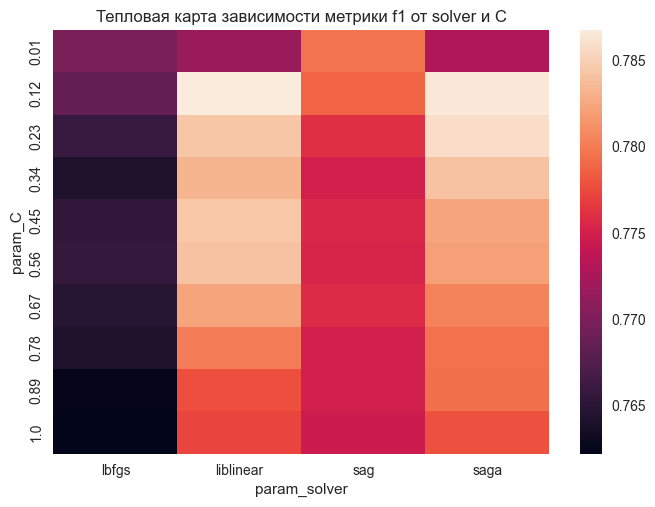

In [198]:
# отрисуем, как менялась f1-score при различных гиперпараметрах
result_cv_lr_grid = pd.DataFrame(grid_search_lr.cv_results_)
visual_lr_grid = pd.pivot_table(result_cv_lr_grid,
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual_lr_grid)
plt.title('Тепловая карта зависимости метрики f1 от solver и С') 
sns.set(rc={'figure.figsize':(9, 6)})

Значения целевой метрики при использовании алгоритмов оптимизации lbfgs и sag ниже на всем диапазоне значений уровня силы регуляризации. Отсюда можно сделать вывод: для данной модели предпочтительнее использование L1-регуляризации.

Cлучайный лес

In [199]:
# задаем сетку параметров
param_grid_rf = {
                'n_estimators': list(range(100, 600, 100)), # количество деревьев в лесу
                'min_samples_leaf': [5, 7, 9], # минимальное число объектов в листе
                'max_depth': [10, 15, 20, 25] # максимальная глубина деревьев
              }

grid_search_rf = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid_rf, 
    cv=5, 
    n_jobs = -1,
    scoring='f1'
)  
%time grid_search_rf.fit(X_train, y_train)
f1_grid_rf = grid_search_rf.score(X_test, y_test) 
print("f1 на тестовом наборе: {:.3f}".format(f1_grid_rf))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_rf.best_params_))

CPU times: total: 8.19 s
Wall time: 2min 50s
f1 на тестовом наборе: 0.797
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 500}


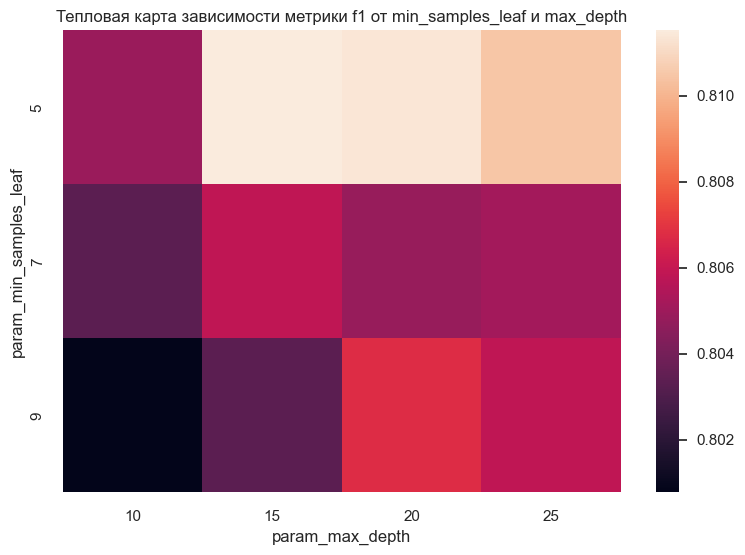

In [200]:
# отрисуем, как менялась f1-score при различных гиперпараметрах
result_cv_rf_grid = pd.DataFrame(grid_search_rf.cv_results_)
visual_rf_grid = pd.pivot_table(result_cv_rf_grid,
                        values='mean_test_score', index='param_min_samples_leaf',
                        columns='param_max_depth')
sns.heatmap(visual_rf_grid)
plt.title('Тепловая карта зависимости метрики f1 от min_samples_leaf и max_depth') 
sns.set(rc={'figure.figsize':(9, 6)})

Модель показывает наилучшие значения целевой метрики при min_samples_leaf = 5.

In [201]:
# зафиксируем результаты, полученные с помощью GridSearchCV
scores_dict['gridsearch'] = [f1_grid_lr, f1_grid_rf]

---

### 2. Подбор гиперпараметров с помощью RandomizedSearchCV

In [202]:

# подбор параметров для модели логистической регрессии
random_search_lr = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42), 
    param_distributions=param_grid_log_reg, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1, 
    scoring='f1'
)

%time random_search_lr.fit(X_train, y_train) 
f1_random_lr = random_search_lr.score(X_test, y_test)
print("f1 на тестовом наборе: {:.3f}".format(f1_random_lr))
print("Наилучшие значения гиперпараметров: {}".format(random_search_lr.best_params_))

CPU times: total: 6.48 s
Wall time: 1min 43s
f1 на тестовом наборе: 0.785
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l1', 'C': 0.23}


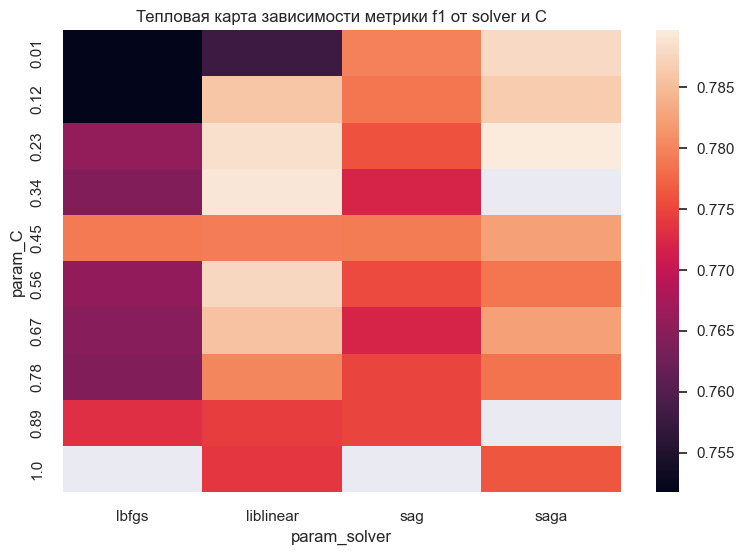

In [203]:
# отрисуем, как менялась f1-score при различных гиперпараметрах
result_cv_lr_random = pd.DataFrame(random_search_lr.cv_results_)
visual_lr_random = pd.pivot_table(result_cv_lr_random,
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual_lr_random)
plt.title('Тепловая карта зависимости метрики f1 от solver и С') 
sns.set(rc={'figure.figsize':(9, 6)})

In [204]:

# подбор параметров для модели случайного леса
random_search_rf = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_grid_rf, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1, 
    scoring='f1'
)

%time random_search_rf.fit(X_train, y_train) 
f1_random_rf = random_search_rf.score(X_test, y_test)
print("f1 на тестовом наборе: {:.3f}".format(f1_random_rf))
print("Наилучшие значения гиперпараметров: {}".format(random_search_rf.best_params_))

CPU times: total: 4.97 s
Wall time: 2min 14s
f1 на тестовом наборе: 0.798
Наилучшие значения гиперпараметров: {'n_estimators': 300, 'min_samples_leaf': 5, 'max_depth': 15}


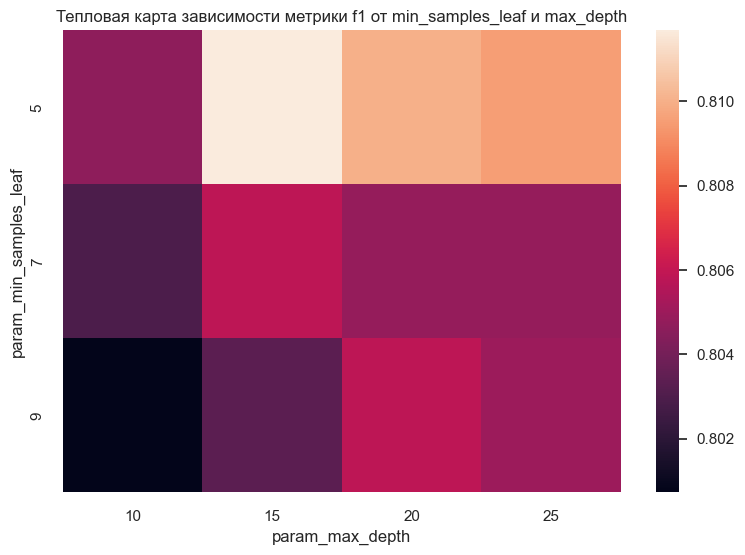

In [205]:
# отрисуем, как менялась f1-score при различных гиперпараметрах
result_cv_rf_random = pd.DataFrame(random_search_rf.cv_results_)
visual_rf_random = pd.pivot_table(result_cv_rf_random,
                        values='mean_test_score', index='param_min_samples_leaf',
                        columns='param_max_depth')
sns.heatmap(visual_rf_random)
plt.title('Тепловая карта зависимости метрики f1 от min_samples_leaf и max_depth') 
sns.set(rc={'figure.figsize':(9, 6)})

Применение RandomizedSearchCV не позволило повысить значения целевой метрики для обеих моделей, однако удалось сократить время подбора гиперпараметров.

In [206]:
# зафиксируем результаты, полученные с помощью RandomizedSearchCV
scores_dict['randomsearch'] = [f1_random_lr, f1_random_rf]

---

### 3. Подбор гиперпараметров с помощью Hyperopt

Начнем с логистической регрессии

In [207]:
# создаем два пространства поиска гиперпараметров
space_1_lr = {
         'penalty': hp.choice('penalty', ['l1', 'l2']) ,
         'solver': hp.choice('solver', ['liblinear', 'saga']),
         'C': hp.uniform('C', 0.01, 1)
        }

space_2_lr = {
         'penalty': hp.choice('penalty', ['l2', 'none']) ,
         'solver': hp.choice('solver', ['lbfgs', 'sag']),
         'C': hp.uniform('C', 0.01, 1)
        }

In [208]:
# зафиксируем random_state
random_state = 42

# объявляем функцию минимизации целевой метрики
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
              'solver': params['solver'], 
             'C': params['C']
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    # score = metrics.f1_score(y, model.predict(X))
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [209]:
%%time
# начинаем подбор гиперпараметров из первого пространства поиска
trials_1 = Trials() # используется для логирования результатов

best_1_lr = fmin(hyperopt_rf, #  функция минимизации
          space=space_1_lr, # первое пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию
          max_evals=20, # максимальное количество итераций
          trials=trials_1, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров первого пространства поиска {}".format(best_1_lr))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [02:06<00:00,  6.34s/trial, best loss: -0.7902865016281384]
Наилучшие значения гиперпараметров первого пространства поиска {'C': 0.2200949458234019, 'penalty': 0, 'solver': 1}
CPU times: total: 1min
Wall time: 2min 6s


In [210]:
# рассчитаем метрику для тестовой выборки с наилучшими параметрами первого пространства поиска
model_1 = linear_model.LogisticRegression(
    random_state=random_state, 
    C=best_1_lr['C'],
    penalty='l1',
    solver='saga'
)

model_1.fit(X_train, y_train)
y_test_pred_1 = model_1.predict(X_test)
f1_hyperopt_1_lr = metrics.f1_score(y_test, y_test_pred_1)

print('f1_score на тестовом наборе: {:.3f}'.format(f1_hyperopt_1_lr))

f1_score на тестовом наборе: 0.785


In [211]:
%%time
# начинаем подбор гиперпараметров из второго пространства поиска
trials_2 = Trials() 

best_2_lr = fmin(hyperopt_rf, 
          space=space_2_lr, 
          max_evals=20, 
          trials=trials_2, 
          rstate=np.random.default_rng(random_state)
         )
print("Наилучшие значения гиперпараметров второго пространства поиска {}".format(best_2_lr))

TPE is being used as the default algorithm.


100%|██████████| 20/20 [01:43<00:00,  5.16s/trial, best loss: -0.7902171664645037]
Наилучшие значения гиперпараметров второго пространства поиска {'C': 0.05084775379720359, 'penalty': 0, 'solver': 0}
CPU times: total: 1min 17s
Wall time: 1min 43s


In [212]:
# рассчитаем метрику для тестовой выборки с наилучшими параметрами второго пространства поиска
model_2 = linear_model.LogisticRegression(
    random_state=random_state, 
    C=best_2_lr['C'],
    penalty='l2',
    solver='lbfgs'
)
model_2.fit(X_train, y_train)
y_test_pred_2 = model_2.predict(X_test)
f1_hyperopt_2_lr = metrics.f1_score(y_test, y_test_pred_2)

print('f1_score на тестовом наборе: {:.3f}'.format(f1_hyperopt_2_lr))

f1_score на тестовом наборе: 0.787


Случайный лес

In [213]:
# задаем пространство поиска гиперпараметров для модели случайного леса
space_rf={'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [214]:
# объявляем функцию минимизации целевой метрики
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)
    model.fit(X, y)
    # score = metrics.f1_score(y, model.predict(X))
    
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    return -score

In [215]:
%%time
# начинаем подбор гиперпараметров для модели случайного леса
trials_rf = Trials() 

best_rf = fmin(hyperopt_rf, 
          space=space_rf, 
          max_evals=20, 
          trials=trials_rf, 
          rstate=np.random.default_rng(random_state)
         )
print("Наилучшие значения гиперпараметров {}".format(best_rf))

TPE is being used as the default algorithm.


100%|██████████| 20/20 [02:31<00:00,  7.55s/trial, best loss: -0.8167017535814063]
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 114.0}
CPU times: total: 1min 13s
Wall time: 2min 31s


In [216]:
# рассчитаем метрику для тестовой выборки
model_rf = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best_rf['n_estimators']),
    max_depth=int(best_rf['max_depth']),
    min_samples_leaf=int(best_rf['min_samples_leaf'])
)
model_rf.fit(X_train, y_train)
y_test_pred_hyp_rf = model_rf.predict(X_test)
f1_hyperopt_rf = metrics.f1_score(y_test, y_test_pred_hyp_rf)
print('f1_score на тестовом наборе: {:.3f}'.format(f1_hyperopt_rf))

f1_score на тестовом наборе: 0.810


Подбор гиперпараметров с помощью Hyperopt позволил добиться более высоких значений целевой метрики для обеих моделей с меньшими временными затратами по сравнению с RandomizedSearchCV и GridSeachCV.

In [217]:
# зафиксируем результаты, полученные с помощью RandomizedSearchCV
scores_dict['hyperopt'] = [f1_hyperopt_2_lr, f1_hyperopt_rf]

---

### 4. Подбор гиперпараметров с помощью Optuna

Логистическая регрессия

In [218]:
# целевая функция
def optuna_lr_1(trial):
  # задаем первое пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
  solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
  C = trial.suggest_float('C',0.01, 1)

  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=random_state)
  
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [219]:
%%time
# cоздаем объект исследования
study_1_lr = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_1_lr.optimize(optuna_lr_1, n_trials=20)
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_1_lr.best_params))

[I 2023-07-21 20:49:29,503] A new study created in memory with name: LogisticRegression
[I 2023-07-21 20:49:33,536] Trial 0 finished with value: 0.8773527625986641 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.9061783268908441}. Best is trial 0 with value: 0.8773527625986641.
[I 2023-07-21 20:49:39,540] Trial 1 finished with value: 0.8546494131808606 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.7349037155077596}. Best is trial 0 with value: 0.8773527625986641.
[I 2023-07-21 20:49:39,784] Trial 2 finished with value: 0.8434237995824635 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.34653254035141784}. Best is trial 0 with value: 0.8773527625986641.
[I 2023-07-21 20:49:40,182] Trial 3 finished with value: 0.8787878787878788 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.37075932667630934}. Best is trial 3 with value: 0.8787878787878788.
[I 2023-07-21 20:49:40,327] Trial 4 finished with value: 0.7837919564560025 and parameters: 

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.9971459031778678}
CPU times: total: 38.6 s
Wall time: 38.3 s


In [220]:
# рассчитаем метрику для тестовой выборки
model_1_lr_optuna = linear_model.LogisticRegression(**study_1_lr.best_params,random_state=random_state )
model_1_lr_optuna.fit(X_train, y_train)
y_test_pred_1_optuna = model_1_lr_optuna.predict(X_test)
f1_optuna_1 = metrics.f1_score(y_test, y_test_pred)
print('f1_score на тестовом наборе: {:.3f}'.format(f1_optuna_1))

f1_score на тестовом наборе: 0.805


In [221]:
optuna.visualization.plot_param_importances(study_1_lr, target_name="f1_score")

In [222]:
optuna.visualization.plot_optimization_history(study_1_lr, target_name="f1_score")

Максимальное значение метрики было достигнуто на шестнадцатой итерации

In [223]:
def optuna_lr_2(trial):
  # задаем второе пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
  solver = trial.suggest_categorical('solver', ['lbfgs', 'sag'])
  C = trial.suggest_float('C',0.01, 1)

  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))
  

  return score

In [224]:
%%time
# cоздаем объект исследования
study_2_lr = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_2_lr.optimize(optuna_lr_2, n_trials=20)
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_2_lr.best_params))

[I 2023-07-21 20:50:08,737] A new study created in memory with name: LogisticRegression
[I 2023-07-21 20:50:09,438] Trial 0 finished with value: 0.8775015160703457 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.333724742396481}. Best is trial 0 with value: 0.8775015160703457.
[I 2023-07-21 20:50:10,049] Trial 1 finished with value: 0.912883435582822 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.5361185640835392}. Best is trial 1 with value: 0.912883435582822.
[I 2023-07-21 20:50:13,638] Trial 2 finished with value: 0.8928679817905918 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 0.06758149320523087}. Best is trial 1 with value: 0.912883435582822.
[I 2023-07-21 20:50:14,294] Trial 3 finished with value: 0.912883435582822 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.4917429396756892}. Best is trial 1 with value: 0.912883435582822.
[I 2023-07-21 20:50:17,979] Trial 4 finished with value: 0.8831562974203339 and parameters: {'penalty

Наилучшие значения гиперпараметров {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.5361185640835392}
CPU times: total: 1min 19s
Wall time: 31.6 s


In [225]:
# рассчитаем метрику для тестовой выборки
model_2_lr_optuna = linear_model.LogisticRegression(**study_2_lr.best_params,random_state=random_state )
model_2_lr_optuna.fit(X_train, y_train)
y_test_pred_2_optuna = model_2_lr_optuna.predict(X_test)
f1_optuna_2 = metrics.f1_score(y_test, y_test_pred)
print('f1_score на тестовом наборе: {:.3f}'.format(f1_optuna_2))

f1_score на тестовом наборе: 0.805


In [226]:
optuna.visualization.plot_param_importances(study_2_lr, target_name="f1_score")

In [227]:
optuna.visualization.plot_optimization_history(study_2_lr, target_name="f1_score")

Максимальное значение метрики было достигнуто на первой итерации

Случайный лес

In [12]:
# целевая функция
def optuna_rf(trial, cv=5, random_state=42):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 300, 500, 1)
    max_depth = trial.suggest_int('max_depth', 13, 16, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 5, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
    # обучаем модель
    model.fit(X_train, y_train)
    # score = metrics.f1_score(y_train, model.predict(X_train))
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1).mean()

    return score

In [13]:
%%time
# cоздаем объект исследования
study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf.optimize(optuna_rf, n_trials=50)
print("Наилучшие значения гиперпараметров {}".format(study_rf.best_params))

[I 2023-07-22 02:21:53,578] A new study created in memory with name: RandomForestClassifier


[I 2023-07-22 02:22:12,825] Trial 0 finished with value: 0.8113361600384954 and parameters: {'n_estimators': 488, 'max_depth': 15, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8113361600384954.
[I 2023-07-22 02:22:27,761] Trial 1 finished with value: 0.8116971610236016 and parameters: {'n_estimators': 433, 'max_depth': 15, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8116971610236016.
[I 2023-07-22 02:22:45,637] Trial 2 finished with value: 0.8151895077540449 and parameters: {'n_estimators': 468, 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8151895077540449.
[I 2023-07-22 02:22:57,620] Trial 3 finished with value: 0.810401698647029 and parameters: {'n_estimators': 340, 'max_depth': 14, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8151895077540449.
[I 2023-07-22 02:23:13,644] Trial 4 finished with value: 0.8146972415522266 and parameters: {'n_estimators': 419, 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8151

Наилучшие значения гиперпараметров {'n_estimators': 472, 'max_depth': 15, 'min_samples_leaf': 2}
CPU times: total: 6min 6s
Wall time: 12min 22s


In [14]:
# рассчитаем метрику для тестовой выборки
model_rf = ensemble.RandomForestClassifier(**study_rf.best_params,random_state=42 )
model_rf.fit(X_train, y_train)
y_test_pred_rf_optuna = model_rf.predict(X_test)
f1_optuna_rf = metrics.f1_score(y_test, y_test_pred_rf_optuna)
print('f1_score на тестовом наборе: {:.3f}'.format(f1_optuna_rf))

f1_score на тестовом наборе: 0.805


In [15]:
optuna.visualization.plot_param_importances(study_rf, target_name="f1_score")

In [16]:
optuna.visualization.plot_optimization_history(study_rf, target_name="f1_score")

Максимальное значение метрики было достигнуто на восьмой итерации

In [253]:
# зафиксируем результаты, полученные с помощью Optuna
scores_dict['optuna'] = [f1_optuna_1, f1_optuna_rf]

Text(0, 0.5, 'f1_score')

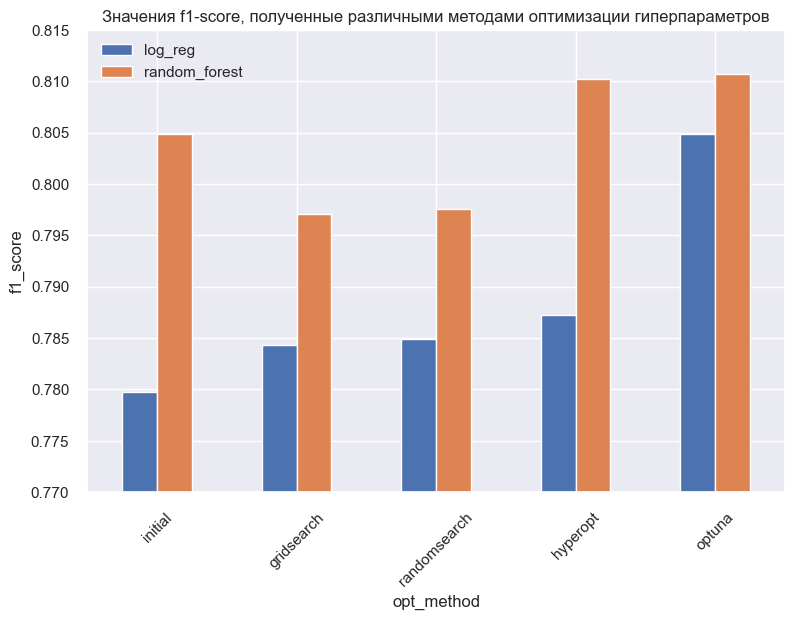

In [254]:
score_df = pd.DataFrame(scores_dict, index=['log_reg', 'random_forest']).T.reset_index().rename(columns={'index': 'opt_method'})
# столбчатая диаграмма значений целевой метрики, полученных различными методами оптимизации гиперпараметров
score_df.plot(x='opt_method', kind='bar', ylim=[0.770, 0.815])
plt.xticks(rotation=45)
plt.title('Значения f1-score, полученные различными методами оптимизации гиперпараметров')
plt.ylabel('f1_score')

По построенной диаграмме можно сделать следующие выводы:
- модель случайного леса позволяет достичь более высоких значений целевой метрики независимо от метода оптимизации гиперпараметров
- базовые методы оптимизации позволили превзойти  значение целевой метрики только дефолтной модели логистической регрессии
- с помощью методов продвинутой оптимизации улучшены значения целевой метрики обеих дефолтных моделей.